Before augmentation:
Class 0: 38 samples
Class 1: 9562 samples
Minority class: 0
Minority windows shape: (38, 400, 1)
1/1 [==============================] - 2s 2s/step


Epoch 0/5000 [D loss: 0.6945, acc: 31.25%] [G loss: 0.6808]
1/1 [==============================] - 0s 22ms/step
Epoch 1000/5000 [D loss: 0.7293, acc: 12.50%] [G loss: 0.7358]
1/1 [==============================] - 0s 22ms/step
Epoch 2000/5000 [D loss: 0.7069, acc: 29.69%] [G loss: 0.7386]
1/1 [==============================] - 0s 21ms/step
Epoch 3000/5000 [D loss: 0.6850, acc: 48.44%] [G loss: 0.7349]
1/1 [==============================] - 0s 23ms/step
Epoch 4000/5000 [D loss: 0.6726, acc: 54.69%] [G loss: 0.7737]
63/63 [==============================] - 1s 7ms/step


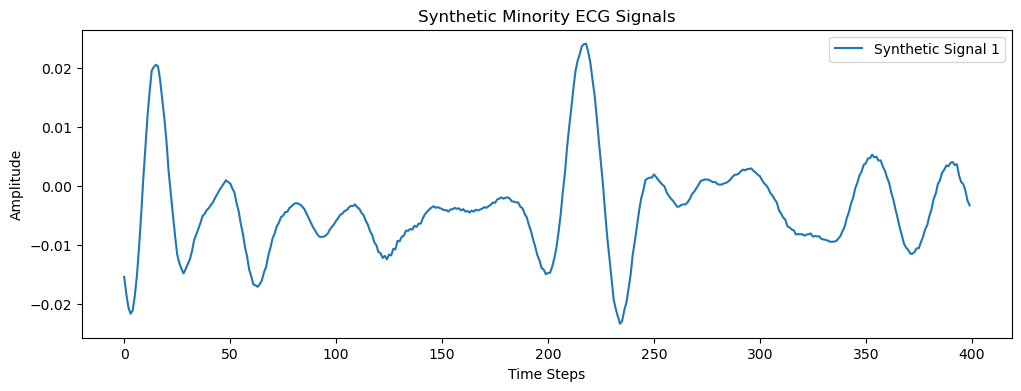

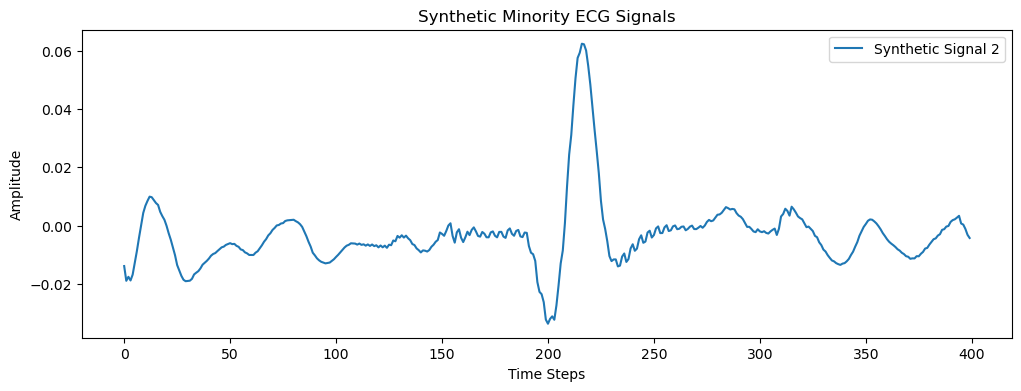

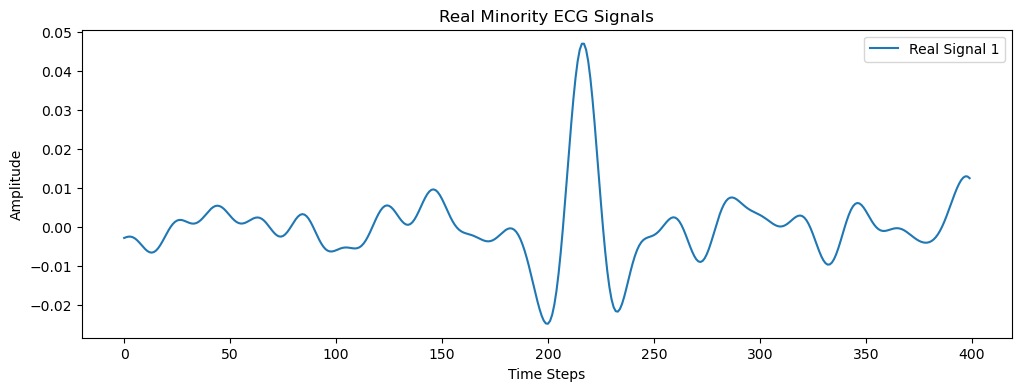

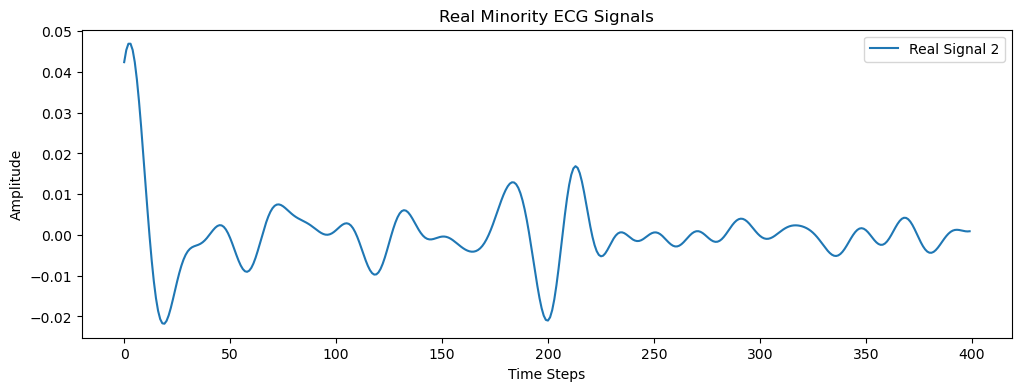

D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Models saved successfully.


In [9]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, UpSampling1D, Reshape, Flatten, Input, LeakyReLU
from tensorflow.keras.optimizers import legacy  # Use legacy optimizers to avoid variable recognition issues
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf

#############################################
# 1. Data Loading and Window Segmentation
#############################################

# Load the annotated dataset
file_path = "fetal_ecg_annotations.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Preprocess the data
# Here we assume that each row in 'Fetal ECG' is a signal (or one value per row if already segmented).
# For this example, we reshape to (-1, 1) so that we can slide a window over the rows.
X = -data['Fetal ECG'].values.reshape(-1, 1)
y = data['Annotation'].values  # Expected labels: "N" or "A"

# Encode labels: for example, 'N' -> 0, 'A' -> 1 (or vice versa, depending on your data)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Set window size to match the pretrained model's expected input shape.
window_size = 400 # Adjust as needed

X_windows = []
y_windows = []

# Create windows using a sliding window across the dataset.
# For simplicity, this example slides one row at a time.
for i in range(len(X) - window_size):
    # Concatenate rows from i to i+window_size and flatten into a 1D array.
    window = X[i : i + window_size].flatten()
    X_windows.append(window)
    # Use the label at the midpoint of the window as the window label.
    y_windows.append(y[i + window_size // 2])

X_windows = np.array(X_windows)  # Shape: (num_windows, window_size)
y_windows = np.array(y_windows)

# Check class distribution before augmentation
unique, counts = np.unique(y_windows, return_counts=True)
print("Before augmentation:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

# Identify the minority class (here, the one with lower count)
minority_class = unique[np.argmin(counts)]
print(f"Minority class: {minority_class}")

#############################################
# 2. GAN for Minority Class Augmentation
#############################################

# Extract windows corresponding to the minority class.
X_minority = X_windows[y_windows == minority_class]
# Reshape to add a channel dimension for Conv1D: (samples, window_size, 1)
X_minority = X_minority.reshape(-1, window_size, 1)
print("Minority windows shape:", X_minority.shape)

# GAN Hyperparameters
latent_dim =50 # Dimensionality of the noise vector
gan_epochs = 5000     # Number of GAN training epochs (adjust as needed)
batch_size_gan = 32
sample_interval = 1000  # Interval (in epochs) to print training progress

# Define the generator model
def build_generator(latent_dim, output_length):
    model = Sequential()
    # Ensure that output_length is divisible by 8 for this architecture
    n_nodes = 128 * (output_length // 8)
    model.add(Dense(n_nodes, activation="relu", input_dim=latent_dim))
    model.add(Reshape((output_length // 8, 128)))  # Reshape to (output_length//8, 128)
    
    # Upsample three times to reach the desired output length
    model.add(UpSampling1D())
    model.add(Conv1D(128, kernel_size=7, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(UpSampling1D())
    model.add(Conv1D(64, kernel_size=7, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(UpSampling1D())
    # Final convolution: output one channel with tanh activation (values in [-1, 1])
    model.add(Conv1D(1, kernel_size=7, padding="same", activation="tanh"))
    return model

# Define the discriminator model
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=7, strides=2, input_shape=input_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(64, kernel_size=7, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Use the legacy Adam optimizer to avoid variable recognition issues.
optimizer = legacy.Adam(learning_rate=0.0002, beta_1=0.5)

# Build and compile the discriminator
discriminator = build_discriminator((window_size, 1))
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Build the generator
generator = build_generator(latent_dim, window_size)

# Build the combined GAN model
z = Input(shape=(latent_dim,))
generated_window = generator(z)
discriminator.trainable = False  # Freeze the discriminator during generator training
validity = discriminator(generated_window)
gan = Model(z, validity)
gan.compile(loss="binary_crossentropy", optimizer=optimizer)

# Train the GAN on the minority windows
for epoch in range(gan_epochs):
    # ---------------------
    #  Train the Discriminator
    # ---------------------
    idx = np.random.randint(0, X_minority.shape[0], batch_size_gan)
    real_windows = X_minority[idx]
    real_labels = np.ones((batch_size_gan, 1))
    
    noise = np.random.normal(0, 1, (batch_size_gan, latent_dim))
    fake_windows = generator.predict(noise)
    fake_labels = np.zeros((batch_size_gan, 1))
    
    d_loss_real = discriminator.train_on_batch(real_windows, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_windows, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # ---------------------
    #  Train the Generator
    # ---------------------
    noise = np.random.normal(0, 1, (batch_size_gan, latent_dim))
    valid_y = np.ones((batch_size_gan, 1))  # Try to fool the discriminator
    g_loss = gan.train_on_batch(noise, valid_y)
    
    if epoch % sample_interval == 0:
        print(f"Epoch {epoch}/{gan_epochs} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

# Generate synthetic minority samples using the trained generator
num_synthetic = 2000  # Number of synthetic samples to generate
noise = np.random.normal(0, 1, (num_synthetic, latent_dim))
synthetic_samples = generator.predict(noise)
# Reshape synthetic samples from (num_synthetic, window_size, 1) to (num_synthetic, window_size)
synthetic_samples = synthetic_samples.reshape(num_synthetic, window_size)
synthetic_labels = np.array([minority_class] * num_synthetic)

# -------------------------------
# Plot 2 Synthetic Signals
# -------------------------------
plt.figure(figsize=(12, 4))
plt.plot(synthetic_samples[0], label="Synthetic Signal 1")
plt.title("Synthetic Minority ECG Signals")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(synthetic_samples[1], label="Synthetic Signal 2")
plt.title("Synthetic Minority ECG Signals")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
# -------------------------------
# Plot 2 Real Minority Signals
# -------------------------------
# Here we plot two real minority windows from X_minority.
plt.figure(figsize=(12, 4))
plt.plot(X_minority[0].reshape(window_size), label="Real Signal 1")
plt.title("Real Minority ECG Signals")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(X_minority[1].reshape(window_size), label="Real Signal 2")
plt.title("Real Minority ECG Signals")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
# Save each model in HDF5 format (or any format supported by Keras)
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")
gan.save("gan_model.h5")
print("Models saved successfully.")

In [7]:
# Combine the original windows with the synthetic minority samples
X_windows_augmented = np.vstack([X_windows, synthetic_samples])
y_windows_augmented = np.hstack([y_windows, synthetic_labels])

# Verify class distribution after augmentation
unique_aug, counts_aug = np.unique(y_windows_augmented, return_counts=True)
print("After augmentation:")
for cls, count in zip(unique_aug, counts_aug):
    print(f"Class {cls}: {count} samples")

# Reshape for Conv1D input: (samples, window_size, 1)
X_windows_augmented = X_windows_augmented.reshape(X_windows_augmented.shape[0], window_size, 1)

#############################################
# 4. Fine-Tune the Pretrained Model on the Augmented Data
#############################################

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_windows_augmented, y_windows_augmented, test_size=0.2, random_state=42)

# Load the pretrained model
pretrained_model_path = "MIT.h5"  # Replace with your pretrained model path
pretrained_model = load_model(pretrained_model_path)

# Fine-tuning: Freeze all layers except the last 3 layers (adjust as needed)
for layer in pretrained_model.layers[:-3]:
    layer.trainable = False

# Modify the model: reuse all layers except the final output layer and add a new output layer.
# To avoid name conflicts, we specify a unique name for the new Dropout layer.
model = Sequential(pretrained_model.layers[:-1])
model.add(Dropout(0.3, name="dropout_ft"))
model.add(Dense(1, activation='sigmoid'))  # New output layer for binary classification

# Compile the fine-tuning model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Save the fine-tuned model
model.save("fine_tuned_fetal_arrhythmia_model.h5")

# Plot training history: Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training history: Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Fine-Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

After augmentation:
Class 0: 2037 samples
Class 1: 9363 samples
Epoch 1/100


ValueError: in user code:

    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "D:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 400, 1), found shape=(32, 600, 1)


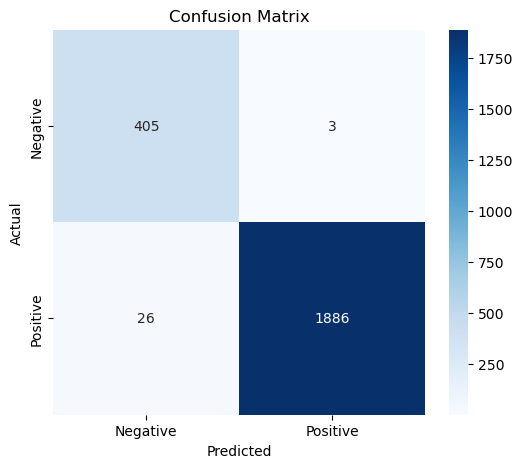

Sensitivity (Recall): 0.9864
Specificity: 0.9926


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate Sensitivity and Specificity
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

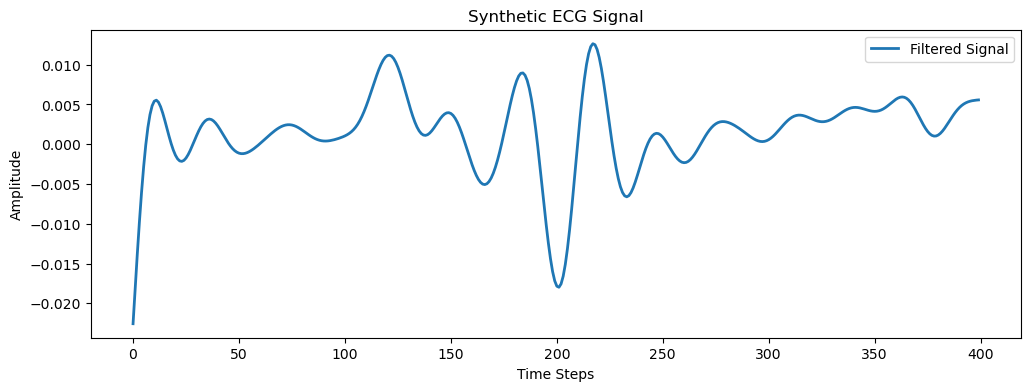

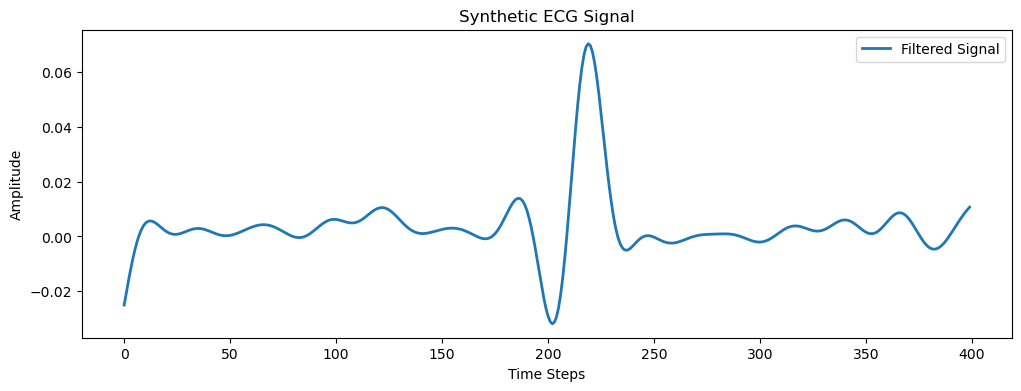

In [2]:
from scipy.signal import butter, filtfilt

# Define a Butterworth Low-Pass Filter
def butter_lowpass_filter(data, cutoff_freq, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Define Sampling Frequency (fs) and Cutoff Frequency
fs = 1000  # Adjust based on your data (ECG is typically 250-1000 Hz)
cutoff_freq = 40  # Common cutoff for ECG, keeping QRS but removing high-freq noise

# Apply the filter to synthetic ECG signals
filtered_synthetic_samples = np.array([butter_lowpass_filter(sig, cutoff_freq, fs) for sig in synthetic_samples])

# Plot Original vs. Filtered ECG Signals
plt.figure(figsize=(12, 4))
plt.plot(filtered_synthetic_samples[2], label="Filtered Signal", linewidth=2)
plt.title("Synthetic ECG Signal")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(filtered_synthetic_samples[90], label="Filtered Signal", linewidth=2)
plt.title("Synthetic ECG Signal")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

Epoch 1/40
232/232 [==============================] - 15s 49ms/step - loss: 0.5074 - accuracy: 0.8207 - val_loss: 0.4425 - val_accuracy: 0.8270
Epoch 2/40
232/232 [==============================] - 10s 44ms/step - loss: 0.3628 - accuracy: 0.8300 - val_loss: 0.1829 - val_accuracy: 0.8944
Epoch 3/40
232/232 [==============================] - 11s 46ms/step - loss: 0.1051 - accuracy: 0.9791 - val_loss: 0.0480 - val_accuracy: 0.9952
Epoch 4/40
232/232 [==============================] - 10s 44ms/step - loss: 0.0449 - accuracy: 0.9946 - val_loss: 0.0268 - val_accuracy: 0.9968
Epoch 5/40
232/232 [==============================] - 10s 43ms/step - loss: 0.0331 - accuracy: 0.9954 - val_loss: 0.0228 - val_accuracy: 0.9973
Epoch 6/40
232/232 [==============================] - 10s 44ms/step - loss: 0.0305 - accuracy: 0.9956 - val_loss: 0.0212 - val_accuracy: 0.9973
Epoch 7/40
232/232 [==============================] - 11s 45ms/step - loss: 0.0301 - accuracy: 0.9952 - val_loss: 0.0207 - val_accuracy:

D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


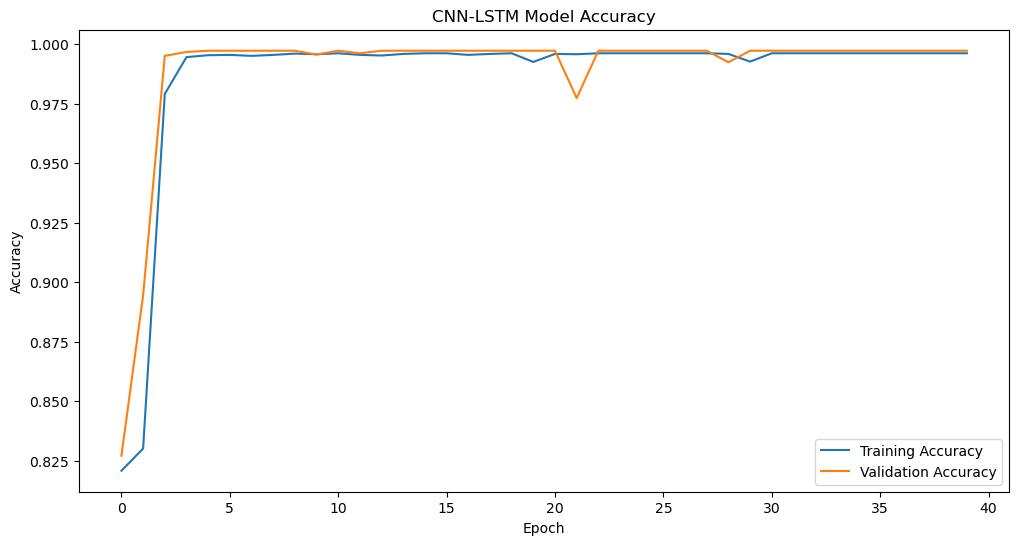

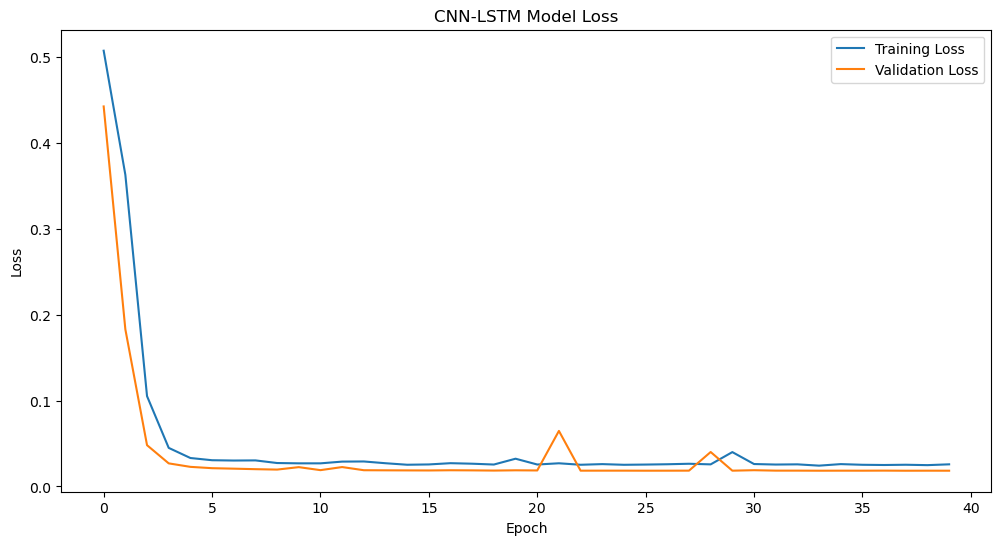

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
X_windows_augmented = np.vstack([X_windows, synthetic_samples])
y_windows_augmented = np.hstack([y_windows, synthetic_labels])
# Reshape for Conv1D input: (samples, window_size, 1)
X_windows_augmented = X_windows_augmented.reshape(X_windows_augmented.shape[0], window_size, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_windows_augmented, y_windows_augmented, test_size=0.2, random_state=42)

# ---------------------- NEW CNN-LSTM MODEL ----------------------
def build_cnn_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# Build and compile the model
input_shape = (window_size, 1)
model = build_cnn_lstm_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Save the trained model
model.save("fetal_arrhythmia_cnn_lstm_model.h5")

# Plot training history: Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training history: Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
model.save("LSTM.h5")

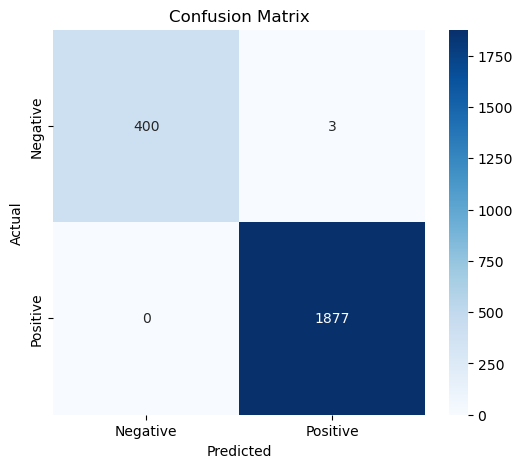

Accuracy: 0.9987
Precision: 0.9984
Sensitivity (Recall): 1.0000
Specificity: 0.9926
F1-Score: 0.9992


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Extract values from confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate performance metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
sensitivity = TP / (TP + FN)  # Same as Recall
specificity = TN / (TN + FP)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)



# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")


# Clinical

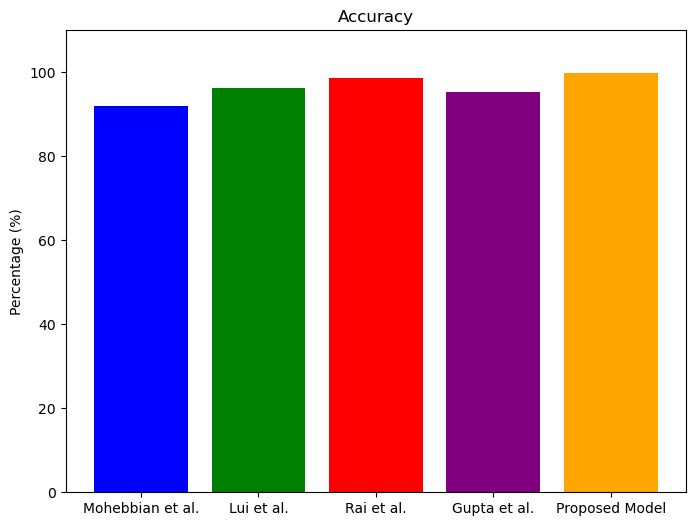

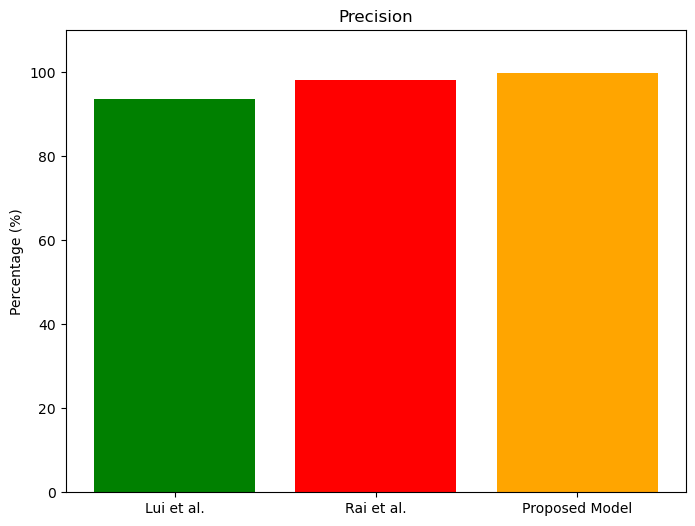

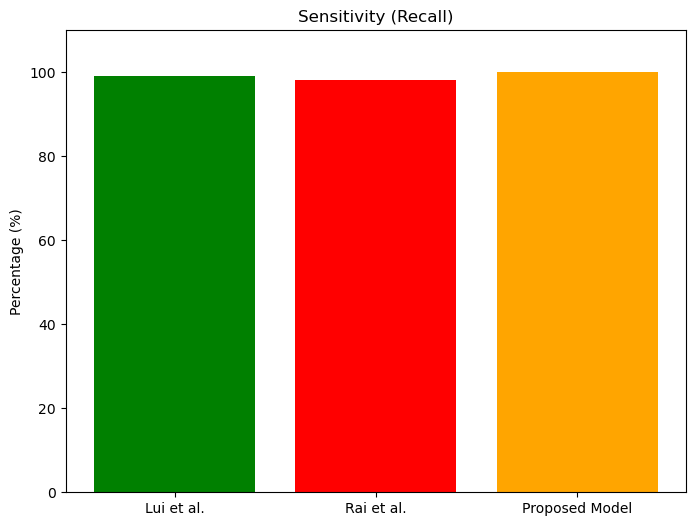

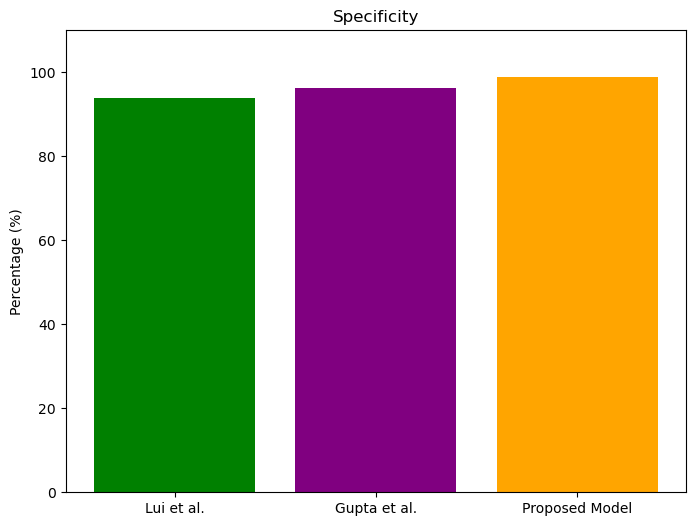

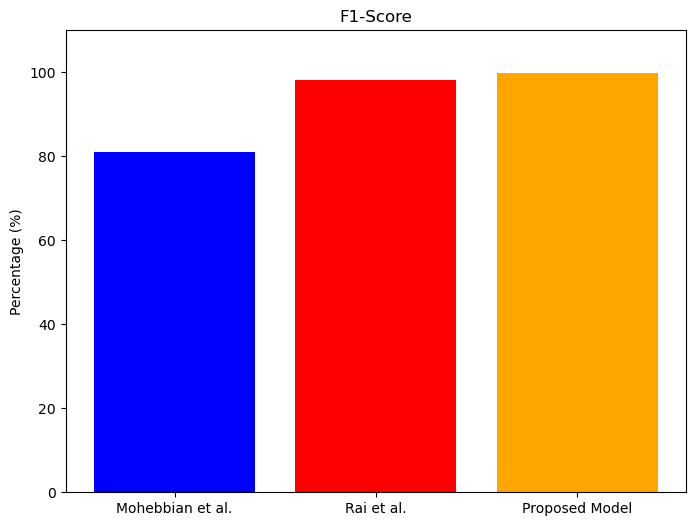

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define models and their performance metrics
models = ["Mohebbian et al.", "Lui et al.", "Rai et al.", "Gupta et al.", "Proposed Model"]
accuracy = [92.00, 96.33, 98.56, 95.31, 99.78]

precision_models = ["Lui et al.", "Rai et al.", "Proposed Model"]
precision = [93.52, 98.28, 99.74]

recall_models = ["Lui et al.", "Rai et al.", "Proposed Model"]
recall = [99.11, 98.27, 99.95]

specificity_models = ["Lui et al.", "Gupta et al.", "Proposed Model"]
specificity = [93.91, 96.29, 98.77]

f1_models = ["Mohebbian et al.", "Rai et al.", "Proposed Model"]
f1_score = [81.00, 98.28, 99.87]

# Define metrics, titles, and colors
metrics = [
    (models, accuracy, "Accuracy"),
    (precision_models, precision, "Precision"),
    (recall_models, recall, "Sensitivity (Recall)"),
    (specificity_models, specificity, "Specificity"),
    (f1_models, f1_score, "F1-Score")
]

# Define unique colors for models
model_colors = {
    "Mohebbian et al.": "blue",
    "Lui et al.": "green",
    "Rai et al.": "red",
    "Gupta et al.": "purple",
    "Proposed Model": "orange"
}

# Plot each metric separately
for model_list, metric, title in metrics:
    plt.figure(figsize=(8, 6))
    colors = [model_colors[m] for m in model_list]  # Assign colors per model
    plt.bar(model_list, metric, color=colors)
    plt.title(title)
    plt.ylim(0, 110)  # Adjust y-axis for better visualization
    plt.ylabel("Percentage (%)")
    plt.xticks()
    
    plt.show()

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input
import numpy as np

# Define CNN-LSTM Model
# Define a reduced complexity CNN-LSTM model
def build_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Reduce filter size and kernel size
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Use fewer LSTM units and remove one LSTM layer
    x = LSTM(32, return_sequences=False)(x)  
    
    x = Dropout(0.3)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs, outputs)
    return model


# Example Input Shape
input_shape = (400, 1)  # (Time steps, Features)
model = build_cnn_lstm_model(input_shape)

# Print Model Summary
model.summary()

# Function to Compute Multiplications & Additions
def compute_operations(model, input_shape):
    total_multiplications = 0
    total_additions = 0

    # Get Model Layers
    for layer in model.layers:
        if isinstance(layer, Conv1D):
            filters = layer.filters
            kernel_size = layer.kernel_size[0]
            input_channels = layer.input_shape[-1]
            output_length = layer.output_shape[1]

            multiplications = output_length * filters * (kernel_size * input_channels)
            additions = multiplications  # Same as multiplications

            total_multiplications += multiplications
            total_additions += additions

        elif isinstance(layer, LSTM):
            input_size = layer.input_shape[-1]
            hidden_size = layer.units

            multiplications = 4 * (input_size + hidden_size) * hidden_size
            additions = multiplications  # Same as multiplications

            total_multiplications += multiplications
            total_additions += additions

        elif isinstance(layer, Dense):
            input_size = layer.input_shape[-1]
            output_size = layer.units

            multiplications = input_size * output_size
            additions = multiplications  # Same as multiplications

            total_multiplications += multiplications
            total_additions += additions

    return total_multiplications, total_additions

# Compute Multiplications & Additions
multiplications, additions = compute_operations(model, input_shape)

# Print Computational Cost
print(f"\n🔹 Total Multiplications: {multiplications:,}")
print(f"🔹 Total Additions: {additions:,}")

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 400, 1)]          0         
                                                                 
 conv1d_25 (Conv1D)          (None, 400, 32)           128       
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 200, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_26 (Conv1D)          (None, 200, 64)           6208      
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 100, 64)           0         
 ng1D)                                                           
                                                                 
 lstm_13 (LSTM)              (None, 32)                124

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input
import numpy as np

# Define CNN Model
def build_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs, outputs)
    return model

# Example Input Shape
input_shape = (400, 1)  # (Time steps, Features)
model = build_cnn_model(input_shape)

# Print Model Summary
model.summary()

# Function to Compute Multiplications & Additions
def compute_operations(model):
    total_multiplications = 0
    total_additions = 0

    # Get Model Layers
    for layer in model.layers:
        if isinstance(layer, Conv1D):
            filters = layer.filters
            kernel_size = layer.kernel_size[0]
            input_channels = layer.input_shape[-1]
            output_length = layer.output_shape[1]

            multiplications = output_length * filters * (kernel_size * input_channels)
            additions = multiplications  # Same as multiplications

            total_multiplications += multiplications
            total_additions += additions

        elif isinstance(layer, Dense):
            input_size = layer.input_shape[-1]
            output_size = layer.units

            multiplications = input_size * output_size
            additions = multiplications  # Same as multiplications

            total_multiplications += multiplications
            total_additions += additions

    return total_multiplications, total_additions

# Compute Multiplications & Additions
multiplications, additions = compute_operations(model)

# Print Computational Cost
print(f"\n🔹 Total Multiplications: {multiplications:,}")
print(f"🔹 Total Additions: {additions:,}")
print(f"🔹 Total Operations (Mul + Add): {multiplications + additions:,}")


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 400, 1)]          0         
                                                                 
 conv1d_21 (Conv1D)          (None, 400, 64)           384       
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 200, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_22 (Conv1D)          (None, 200, 128)          41088     
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 100, 128)          0         
 ng1D)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0   

Epoch 1/40
232/232 [==============================] - 5s 17ms/step - loss: 0.3074 - accuracy: 0.8866 - val_loss: 0.0534 - val_accuracy: 0.9962
Epoch 2/40
232/232 [==============================] - 4s 18ms/step - loss: 0.0327 - accuracy: 0.9956 - val_loss: 0.0221 - val_accuracy: 0.9973
Epoch 3/40
232/232 [==============================] - 5s 20ms/step - loss: 0.0220 - accuracy: 0.9958 - val_loss: 0.0189 - val_accuracy: 0.9962
Epoch 4/40
232/232 [==============================] - 4s 18ms/step - loss: 0.0219 - accuracy: 0.9954 - val_loss: 0.0167 - val_accuracy: 0.9973
Epoch 5/40
232/232 [==============================] - 4s 16ms/step - loss: 0.0211 - accuracy: 0.9953 - val_loss: 0.0158 - val_accuracy: 0.9973
Epoch 6/40
232/232 [==============================] - 4s 17ms/step - loss: 0.0203 - accuracy: 0.9958 - val_loss: 0.0154 - val_accuracy: 0.9973
Epoch 7/40
232/232 [==============================] - 4s 19ms/step - loss: 0.0190 - accuracy: 0.9961 - val_loss: 0.0155 - val_accuracy: 0.9968

D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


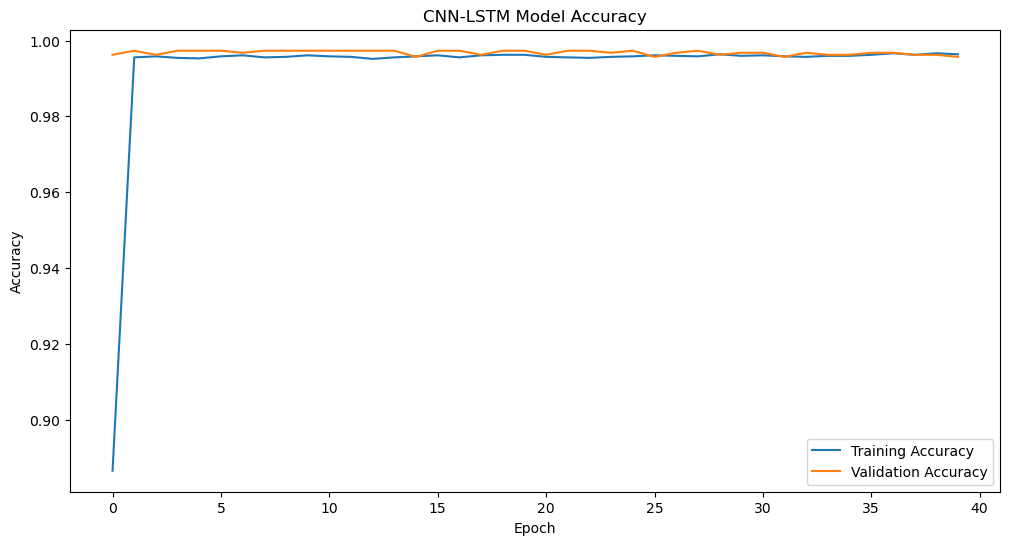

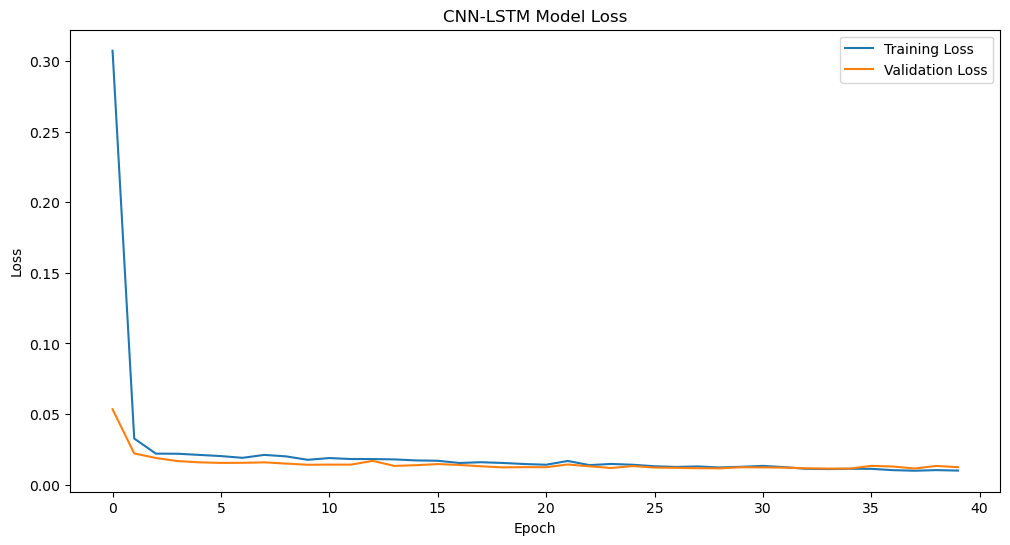

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
X_windows_augmented = np.vstack([X_windows, synthetic_samples])
y_windows_augmented = np.hstack([y_windows, synthetic_labels])
# Reshape for Conv1D input: (samples, window_size, 1)
X_windows_augmented = X_windows_augmented.reshape(X_windows_augmented.shape[0], window_size, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_windows_augmented, y_windows_augmented, test_size=0.2, random_state=42)

# Define CNN Model
def build_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs, outputs)
    return model

# Build and compile the model
input_shape = (window_size, 1)
model = build_cnn_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Save the trained model
model.save("fetal_arrhythmia_cnn_lstm_model.h5")

# Plot training history: Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training history: Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
model.save("CNN.h5")

In [16]:
def build_optimized_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Reduce filter size and kernel size
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Use fewer LSTM units and remove one LSTM layer
    x = LSTM(32, return_sequences=False)(x)  
    
    x = Dropout(0.3)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs, outputs)
    return model

Epoch 1/40
232/232 [==============================] - 6s 21ms/step - loss: 0.5479 - accuracy: 0.8231 - val_loss: 0.4584 - val_accuracy: 0.8270
Epoch 2/40
232/232 [==============================] - 4s 17ms/step - loss: 0.4652 - accuracy: 0.8237 - val_loss: 0.4547 - val_accuracy: 0.8270
Epoch 3/40
232/232 [==============================] - 4s 16ms/step - loss: 0.4569 - accuracy: 0.8237 - val_loss: 0.4353 - val_accuracy: 0.8270
Epoch 4/40
232/232 [==============================] - 4s 17ms/step - loss: 0.3272 - accuracy: 0.8253 - val_loss: 0.1916 - val_accuracy: 0.8594
Epoch 5/40
232/232 [==============================] - 4s 19ms/step - loss: 0.1450 - accuracy: 0.9498 - val_loss: 0.1202 - val_accuracy: 0.9779
Epoch 6/40
232/232 [==============================] - 4s 17ms/step - loss: 0.1233 - accuracy: 0.9832 - val_loss: 0.0963 - val_accuracy: 0.9919
Epoch 7/40
232/232 [==============================] - 4s 17ms/step - loss: 0.1036 - accuracy: 0.9871 - val_loss: 0.0942 - val_accuracy: 0.9790

D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


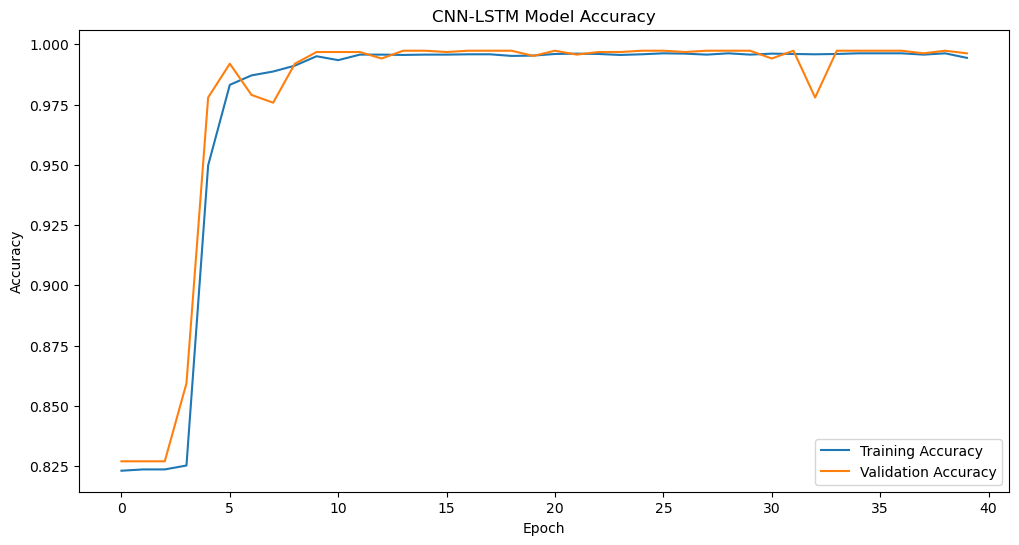

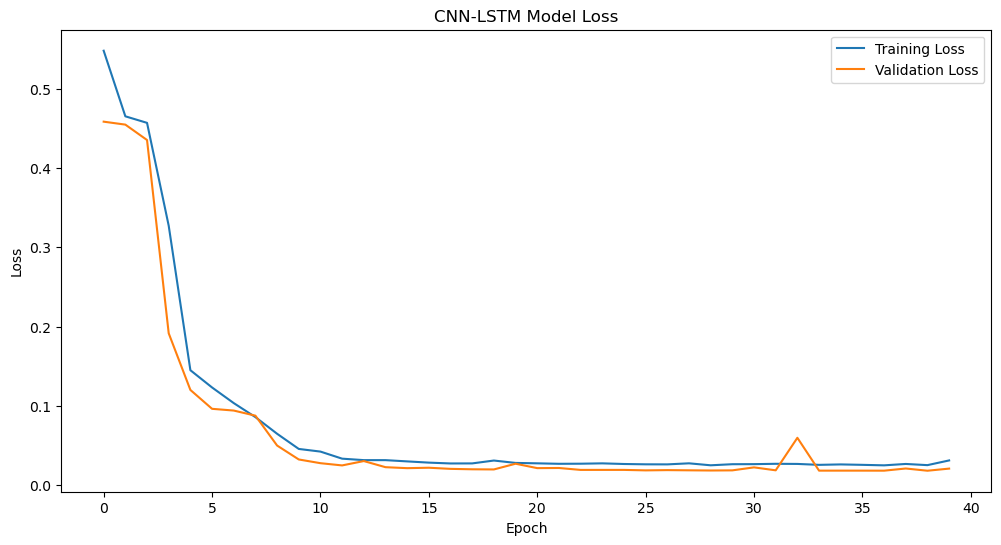

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
X_windows_augmented = np.vstack([X_windows, synthetic_samples])
y_windows_augmented = np.hstack([y_windows, synthetic_labels])
# Reshape for Conv1D input: (samples, window_size, 1)
X_windows_augmented = X_windows_augmented.reshape(X_windows_augmented.shape[0], window_size, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_windows_augmented, y_windows_augmented, test_size=0.2, random_state=42)

# ---------------------- NEW CNN-LSTM MODEL ----------------------
def build_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Reduce filter size and kernel size
    x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Use fewer LSTM units and remove one LSTM layer
    x = LSTM(32, return_sequences=False)(x)  
    
    x = Dropout(0.3)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs, outputs)
    return model

# Build and compile the model
input_shape = (window_size, 1)
model = build_cnn_lstm_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Save the trained model
model.save("fetal_arrhythmia_cnn_lstm_model.h5")

# Plot training history: Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training history: Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
